In [1]:
import tushare as ts
import numpy as np 
import pandas as pd 
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from statsmodels import api as sm 



# 数据准备

In [2]:
token = 'd9c35edffff16c8f0668cc226b492bcf8d4102be94328eca5b884ea0'
# 未经允许，以上token禁止商用
ts.set_token(token)
pro = ts.pro_api()

all_stocks = pro.stock_basic() # 获取所有上市公司

# 随机选择10支2018年1月1日上市前的股票
stocks = all_stocks.query('list_date < "20180101"').sample(10, random_state = 1) 

In [3]:
# 获取每支股票收盘价，并汇总在一起
close_df = pd.DataFrame()
for ts_code in stocks['ts_code']:
    df = ts.pro_bar(ts_code = ts_code, adj='qfq', start_date='20180101')
    df = df.set_index('trade_date') # 以交易日期作为表索引
    close_df[ts_code] = df['close']
    
close_df = close_df.sort_index() # 以交易日期排序
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅

risk_free = 0.03  # 无风险利率

In [4]:
mean_return = return_df.mean().values # 各个标的平均日回报率 
cov_return = return_df.cov().values # 各个标的协方差矩阵
# Note: 以上两个变量都为全局变量

In [5]:
def get_return_of_portfolio(Ws):
    '''
    用途：获取组合的期望年回报率
    Ws：各个标的投资权重。一维数组形式
    mean_return：各资产标的平均日回报率
    '''
    return Ws @ mean_return * 252

def get_variance_of_portfolio(Ws):
    '''
    用途：获取组合的方差
    Ws: 各个标的投资权重
    cov_mat: 各个标的协方差矩阵
    '''
    return Ws.T @ cov_return @ Ws * 252


def get_negative_sharpe(Ws):
    '''
    用途：获取组合的夏普比率负值
    Ws: 各个标的投资权重
    cov_mat: 各个标的协方差矩阵
    '''
    R = get_return_of_portfolio(Ws)
    Var = get_variance_of_portfolio(Ws)
    sharpe = (R - risk_free) / Var**0.5
    return -sharpe

def get_negative_utility(Ws):
    '''
    获取组合的负效用值
    A : 风险险恶系数
    mean_return：各资产标的平均日回报率
    cov_mat: 各个标的协方差矩阵
    '''
    R = get_return_of_portfolio(Ws)
    Var = get_variance_of_portfolio(Ws)
    U = (R  - 0.5*A*Var)
    return -U

def get_minimize_variance_portfolio(mean_return, cov_return):
    '''
    通过公式求取最小方差组合（允许做空）的各个标权重
    mean_return：各资产标的平均日回报率
    cov_mat: 各个标的协方差矩阵
    '''
    n = len(mean_return)
    e = np.ones(n)
    cov_inverse = np.linalg.inv(cov_return)
    Ws = (cov_inverse @ e ) / (e.T @ np.linalg.inv(cov_return) @ e)
    return Ws



# 模型一：全风险资产组合（只能做多）
## 目标1: 组合风险最小

In [6]:
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}, # 各个标的权重之和为1
        {'type': 'ineq', 'fun': lambda Ws: Ws } ] # 各个标的的权重大于等于0
    
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_variance_of_portfolio, x0, method = 'SLSQP', constraints = cons)

if res['success']:
    Ws = res['x']
    Var = res['fun']
    R = get_return_of_portfolio(Ws)
    sharpe = -get_negative_sharpe(Ws)
    print('组合各个标的权重为:', Ws)
    print('组合期望年回报率:',R)
    print('组合方差：', Var)
    print('组合夏普比率：', sharpe)

组合各个标的权重为: [7.01988385e-02 7.87501775e-02 1.51971784e-01 1.47722546e-18
 4.91366847e-02 8.27872751e-02 3.63176356e-01 1.59006418e-01
 9.35153191e-03 3.56209341e-02]
组合期望年回报率: 0.17050755416728577
组合方差： 0.06189341823569909
组合夏普比率： 0.5647775690918426


## 目标2: 最大夏普比率

In [7]:
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}, # 各个标的权重之和为1
        {'type': 'ineq', 'fun': lambda Ws: Ws } ] # 各个标的的权重大于等于0
    
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_negative_sharpe, x0, method = 'SLSQP', constraints = cons)
res 

if res['success']:
    Ws = res['x']
    Var = get_variance_of_portfolio(Ws)
    R = get_return_of_portfolio(Ws)
    sharpe = -get_negative_sharpe(Ws)
    print('组合各个标的权重为:', Ws)
    print('组合期望年回报率:',R)
    print('组合方差：', Var)
    print('组合夏普比率：', sharpe)

组合各个标的权重为: [ 3.70778398e-01  4.47327132e-02  2.17522302e-01 -2.10036167e-16
  6.77873182e-02 -5.08793936e-16 -7.44782847e-17  2.99179268e-01
  5.55580578e-17 -3.10495053e-17]
组合期望年回报率: 0.3763214608627192
组合方差： 0.09896946807174363
组合夏普比率： 1.1008516221869409


# 模型二：全风险资产组合（可做空）

## 目标1:组合风险最小

In [8]:
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}] # 各个标的权重之和为1
    
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_variance_of_portfolio, x0, method = 'SLSQP', constraints = cons)

if res['success']:
    Ws = res['x']
    Var = res['fun']
    R = get_return_of_portfolio(Ws)
    sharpe = -get_negative_sharpe(Ws)
    print('组合各个标的权重为:', Ws)
    print('组合期望年回报率:',R)
    print('组合方差：', Var)
    print('组合夏普比率：', sharpe)

组合各个标的权重为: [ 0.07126706  0.08017028  0.15267264 -0.022771    0.05247087  0.08353657
  0.36781496  0.16176714  0.01298678  0.04008469]
组合期望年回报率: 0.174056728496589
组合方差： 0.061763999940688416
组合夏普比率： 0.5796500008795483


## 目标2:组合夏普比率最大

In [9]:
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}] # 各个标的权重之和为1
    
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_negative_sharpe, x0, method = 'SLSQP', constraints = cons)

if res['success']:
    Ws = res['x']
    Var = get_variance_of_portfolio(Ws)
    R = get_return_of_portfolio(Ws)
    sharpe = -get_negative_sharpe(Ws)
    print('组合各个标的权重为:', Ws)
    print('组合期望年回报率:',R)
    print('组合方差：', Var)
    print('组合夏普比率：', sharpe)

组合各个标的权重为: [ 0.78469323  0.2372463   0.54459085 -0.27618637  0.4754204  -0.6274528
 -0.03576748  0.61117092  0.11144807 -0.82516312]
组合期望年回报率: 1.2030427326923383
组合方差： 0.502855974564726
组合夏普比率： 1.654215272254053


# 模型三：可配置现金的资产组合（只能做多）

## 目标1:组合夏普比率最大

In [10]:
# 引入无风险资产收益率，重新计算各资产标的平均回报率以及协方差
return_df['risk_free'] = risk_free / 252
mean_return = return_df.mean().values
cov_return = return_df.cov().values

In [11]:
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}, # 各个标的权重之和为1
        {'type': 'ineq', 'fun': lambda Ws: Ws } ] # 各个标的的权重大于等于0
    
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_negative_sharpe, x0, method = 'SLSQP', constraints = cons)
res 

if res['success']:
    Ws = res['x']
    Var = get_variance_of_portfolio(Ws)
    R = get_return_of_portfolio(Ws)
    sharpe = -get_negative_sharpe(Ws)
    print('组合各个标的权重为:', Ws)
    print('组合期望年回报率:',R)
    print('组合方差：', Var)
    print('组合夏普比率：', sharpe)


组合各个标的权重为: [ 3.70757727e-01  4.46666599e-02  2.17363396e-01  2.81424487e-17
  6.77905971e-02 -2.98424633e-16 -7.21965717e-17  2.98775066e-01
  5.15774159e-18  2.98786786e-16  6.46554664e-04]
组合期望年回报率: 0.3761306756314157
组合方差： 0.09886048807020294
组合夏普比率： 1.1008514403513676


# 模型三：可配置现金的资产组合（可做空）

## 目标1:组合夏普比率最大

In [12]:
# 引入无风险资产收益率，重新计算各资产标的平均回报率以及协方差
return_df['risk_free'] = risk_free / 252
mean_return = return_df.mean().values
cov_return = return_df.cov().values


In [13]:
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}] # 各个标的权重之和为1
    
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_negative_sharpe, x0, method = 'SLSQP', constraints = cons)

if res['success']:
    Ws = res['x']
    Var = get_variance_of_portfolio(Ws)
    R = get_return_of_portfolio(Ws)
    sharpe = -get_negative_sharpe(Ws)
    print('组合各个标的权重为:', Ws)
    print('组合期望年回报率:',R)
    print('组合方差：', Var)
    print('组合夏普比率：', sharpe)

组合各个标的权重为: [ 1.28729408  0.38877179  0.89329776 -0.45333646  0.77928154 -1.02955391
 -0.05846921  1.00510239  0.18287756 -1.35385115 -0.64141438]
组合期望年回报率: 1.9550153078814858
组合方差： 1.3542049419466953
组合夏普比率： 1.6542151357899018


# 有效前沿-CML-无差异曲线
## 有效前沿
给定预期回报率，使不含无风险资产组合方差最小

In [14]:
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅
mean_return = return_df.mean().values # 各个标的平均日回报率
cov_return = return_df.cov().values # 各个标的协方差矩阵

# 在得到期望回报的前提下，最小化投资组合的方差
expect_returns = np.linspace(-1 ,2.5,100) # 预期组合回报率
variances = []
for expect_return in expect_returns:
    cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}, # 各个标的权重之和为1
            {'type':'eq', 'fun':lambda Ws: get_return_of_portfolio(Ws)-  expect_return}] # 组合回报率等于期望值
    
    x0 = np.ones(len(mean_return)) / len(mean_return)
    res = optimize.minimize(get_variance_of_portfolio, x0, method = 'SLSQP', constraints = cons)
    if res['success']:
        var = res['fun']
        variances.append(var)
        
stds = np.array(variances)**0.5



## 最小方差组合

In [15]:
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅
mean_return = return_df.mean().values # 各个标的平均日回报率
cov_return = return_df.cov().values # 各个标的协方差矩阵

# 最小化投资组合的方差
Ws = get_minimize_variance_portfolio(mean_return, cov_return )
minimize_var = get_variance_of_portfolio(Ws)
minimize_std = minimize_var**0.5
expect_return = get_return_of_portfolio(Ws)


## 最大夏普组合(不配置无风险资产，可做空)

In [16]:
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅
mean_return = return_df.mean().values
cov_return = return_df.cov().values

# 最大化组合夏普比率（引入无风险资产）
cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}] # 各个标的权重之和为1
x0 = np.ones(len(mean_return)) / len(mean_return)
res = optimize.minimize(get_negative_sharpe, x0, method = 'SLSQP', constraints = cons)

Ws = res['x']
sharpe_return = get_return_of_portfolio(Ws)
sharpe_std = get_variance_of_portfolio(Ws)**0.5
max_sharpe = -get_negative_sharpe(Ws)

print('不配置无风险资产，可做空的组合最大夏普比率:', max_sharpe)

不配置无风险资产，可做空的组合最大夏普比率: 1.654215272254053


## 资本市场线
* Capital Market Line 

给定预期回报率，使含无风险资产组合方差最小(夏普比率最大)

$E(r) = r_f + \sigma  \times \frac{E(r_s) - r_f}{\sigma_s}$

In [17]:
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅

# 引入无风险资产收益率，重新计算各资产标的平均回报率以及协方差
return_df['risk_free'] = risk_free / 252
mean_return = return_df.mean().values
cov_return = return_df.cov().values

CML_std = []
CML_return = np.linspace(risk_free,2.5, 100)
for r in CML_return:
    cons = [{'type':'eq', 'fun':lambda Ws: np.sum(Ws)-1}, # 各个标的权重之和为1
            {'type':'eq', 'fun':lambda Ws: get_return_of_portfolio(Ws)-  r}] # 组合收益等于期望值
    
    x0 = np.ones(len(mean_return)) / len(mean_return)
    res = optimize.minimize(get_variance_of_portfolio, x0, method = 'SLSQP', constraints = cons)
    if res['success']:
        Ws = res['x']
        r = get_return_of_portfolio(Ws)
        var = get_variance_of_portfolio(Ws)
        CML_std.append(var**0.5)


In [18]:
# 以组合标准差为自变量，组合期望回报率为因变量，作回归。
# 验证CML，理论回归截距等于无风险理论，回归斜率等于 最大夏普比率（不配备无风险资产、可做空）
X = sm.add_constant(CML_std) # 对x添加常数项
model = sm.OLS( CML_return, X) # 最小二乘回归
res = model.fit()
res.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     1.000     
Dependent Variable: y                AIC:                -1598.6909
Date:               2021-01-31 12:19 BIC:                -1593.4805
No. Observations:   100              Log-Likelihood:     801.35    
Df Model:           1                F-statistic:        7.925e+09 
Df Residuals:       98               Prob (F-statistic): 0.00      
R-squared:          1.000            Scale:              6.5449e-09
---------------------------------------------------------------------
            Coef.    Std.Err.       t        P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const       0.0300     0.0000    1865.7969   0.0000   0.0299   0.0300
x1          1.6543     0.0000   89022.2731   0.0000   1.6542   1.6543
-------------------------------------------------------------------
Omnibus:              210.656      Durbin-Watson:         1.011    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      34638.321
Skew:                 -9.401       Prob(JB):              0.000    
Kurtosis:             92.217       Condition No.:         4        
===================================================================

"""

## 各个单一资产标的回报率、标准差、夏普比率

In [19]:
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅
mean_return = return_df.mean().values # 各个标的平均日回报率
cov_return = return_df.cov().values # 各个标的协方差矩阵
std_return = return_df.std().values # 各个标的回报标准差
sharpes =  (mean_return*252 - risk_free) / std_return*np.sqrt(252) # 各个标的夏普比率

## 可视化

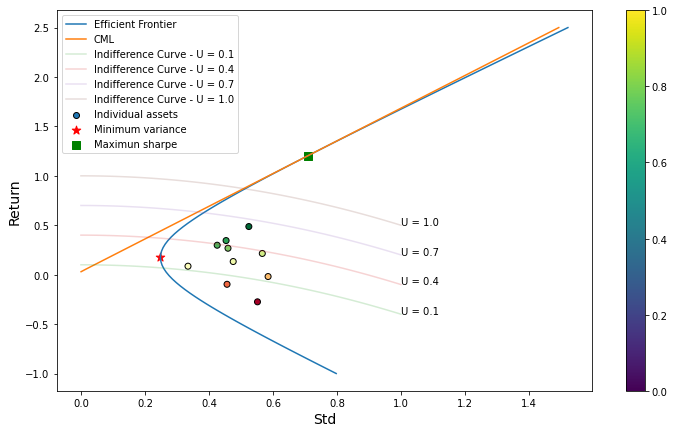

In [26]:
plt.figure(figsize = (12,7))
plt.plot(stds, expect_returns, label = 'Efficient Frontier')

plt.plot(CML_std, CML_return, label = 'CML' )

plt.scatter(std_return*np.sqrt(252), mean_return*252, c  = sharpes, 
             cmap='RdYlGn', edgecolors='black', label = 'Individual assets' )

plt.scatter(minimize_std, expect_return,  marker = '*', s = 80,
            color = 'red' ,label = 'Minimum variance')

plt.scatter(sharpe_std, sharpe_return, marker = 's', s = 50,
             color  = 'green',  label = 'Maximun sharpe' )

# 无差异曲线
A = 1 # 假定投资者的风险险恶系数为1
Indifference_return = np.linspace(risk_free, 1, 100 ) 
Indifference_std = np.linspace(0, 1, 100 ) # 给定组合标准差为为0利率到1之间
Indifference_var = Indifference_std**2

for U in np.linspace(0.1, 1, 4): # 效用从0.1 到 1
    Indifference_return = U - 0.5 * A * Indifference_var
    plt.plot(Indifference_std, Indifference_return, 
             label = 'Indifference Curve - U = {}'.format(U), alpha = 0.2)
    plt.text(Indifference_std[-1], Indifference_return[-1], 'U = {}'.format(U))

plt.xlabel('Std', fontsize = 14)
plt.ylabel('Return', fontsize = 14)
plt.legend(loc = 'upper left')
plt.colorbar()
plt.show()